In [2]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import matplotlib.pyplot as plt
import numpy as np
import random

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [3]:
batch_size = 128
num_classes = 10
epochs = 20

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


60000 train samples
10000 test samples


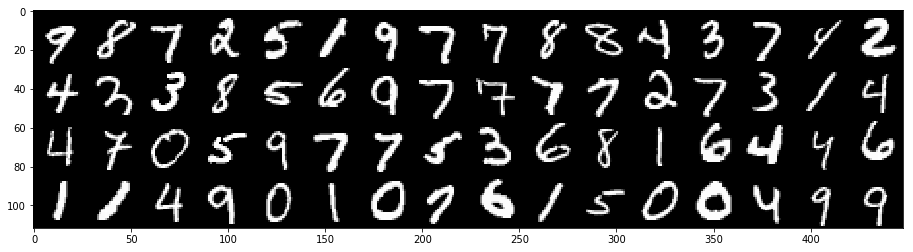

In [4]:
samples = np.concatenate([np.concatenate([x_train[i].reshape(28,28) for i in [int(random.random() * len(x_train)) for i in range(16)]], axis=1) for i in range(4)], axis=0)
plt.figure(figsize=(16,4))
plt.imshow(samples, cmap='gray')

In [5]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))


In [6]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])



In [8]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.2492 - acc: 0.9221 - val_loss: 0.1028 - val_acc: 0.9682
Epoch 2/20
60000/60000 [==============================] - 4s 61us/step - loss: 0.1050 - acc: 0.9682 - val_loss: 0.0914 - val_acc: 0.9739
Epoch 3/20
60000/60000 [==============================] - 4s 61us/step - loss: 0.0742 - acc: 0.9775 - val_loss: 0.0802 - val_acc: 0.9753
Epoch 4/20
60000/60000 [==============================] - 4s 61us/step - loss: 0.0612 - acc: 0.9818 - val_loss: 0.0879 - val_acc: 0.9761
Epoch 5/20
60000/60000 [==============================] - 4s 61us/step - loss: 0.0515 - acc: 0.9849 - val_loss: 0.0877 - val_acc: 0.9759
Epoch 6/20
60000/60000 [==============================] - 4s 61us/step - loss: 0.0467 - acc: 0.9862 - val_loss: 0.0822 - val_acc: 0.9812
Epoch 7/20
60000/60000 [==============================] - 4s 61us/step - loss: 0.0387 - acc: 0.9891 - val_loss: 0.0852 - val_acc

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.10112213116853837
Test accuracy: 0.9842


In [15]:


#import matplotlib.pyplot as plt
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data
labels = iris.target


n = len(labels)

# need to shuffle

shuffle_order = np.random.permutation(len(labels))
X = X[shuffle_order, :]
labels = labels[shuffle_order]


X = X/np.amax(X, axis=0)



batch_size = 20
num_classes = 3
epochs = 20



test_split = 0.3

x_test = X[:int(0.3 * n), :] 
x_train = X[int(0.3 * n):, :] 


y_test = labels[:int(0.3 * n)] 
y_train = labels[int(0.3 * n):] 


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


print(x_train.shape, y_train.shape)

105 train samples
45 test samples
(105, 4) (105, 3)


In [19]:
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(4,)))
#model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_test, y_test))



score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 20)                100       
_________________________________________________________________
dense_20 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 63        
Total params: 583
Trainable params: 583
Non-trainable params: 0
_________________________________________________________________
Train on 105 samples, validate on 45 samples
Epoch 1/50
105/105 [==============================] - 0s 4ms/step - loss: 1.1154 - acc: 0.3238 - val_loss: 1.0833 - val_acc: 0.3556
Epoch 2/50
105/105 [==============================] - 0s 157us/step - loss: 1.0886 - acc: 0.3238 - val_loss: 1.0724 - val_acc: 0.3556
Epoch 3/50
105/105 [==============================] - 0s 152us/step - loss: 1.0765 - acc: 0.3238 